# Generacion de nuestro propio modelo de W2V a partir de los datos de twitter y analisis de similitud entre usuarios a partir de estos vectores

#### lo que hacemos es utilizar una red neuronal para interrelacionar las palabras de un texto. Como?

usando un autoencoder al que luego quitamos la ultima capa, esto nos da los vectores de cada palabra una red neuronal con n entradas (palabras unicas en el texto), m neuronas en capa intermedia, y o neuronas en la salida. el sistema intenta predecir qué palabra vendrá despues de cada palabra de entrada. siendo la palabra un vector de 1Xn.

el sistema aprenderá que palabras con vectores parecidos estan inter relacionadas (pertenecen al mismo tema)

al cortar la capa final, lo que nos queda es una matriz de datos con la probabilidad de aparicion de una palabra para las demas. eso es un vector

# Load Twitter Data

In [5]:
import gensim
import pandas as pd
import pyodbc
import re
from gensim.models import Word2Vec
import numpy as np
from tqdm import tqdm_notebook
from scipy.spatial import distance
from scipy.spatial.distance import mahalanobis
import seaborn as sns 
import matplotlib.pyplot as plt 
from scipy.stats import norm

In [7]:
import configLocal
server = configLocal.server
database = configLocal.database
username = configLocal.username
password = configLocal.password
cnxn = configLocal.cnxn
cursor = cnxn.cursor()

data = pd.read_sql_query("select msg_id, msg_users_id, msg_timestamp, msg_text from dbo.msg", cnxn)

In [8]:
#parse database to dict
corpus = {}
for i in range(data.shape[0]):
    if data.iloc[i]["msg_users_id"] in corpus:
        corpus[data.iloc[i]["msg_users_id"]].append(re.sub(r'http\S+', '', data.iloc[i]["msg_text"], flags=re.MULTILINE))
    else:
        corpus[data.iloc[i]["msg_users_id"]] = [re.sub(r'http\S+', '', data.iloc[i]["msg_text"], flags=re.MULTILINE)]

print(type(corpus), len(corpus))

for i in corpus.keys():
    corpus[i] = gensim.utils.simple_preprocess("".join(corpus[i]).encode('utf-8'), deacc=True, min_len=3)

<class 'dict'> 7157


carga del giga modelo

In [9]:
#now, lets load da big boi model

from numpy import  zeros, float32 as REAL
from gensim.models import keyedvectors
import codecs

# this function was build using code excerpts from:
# https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/keyedvectors.py
def load_vectors_from_csv(fname,vocab_size=973265,vector_size=100):
    print("Loading vectors from file:",fname)
    result=keyedvectors.KeyedVectors(vector_size=100)
    result.syn0 = zeros((vocab_size, vector_size), dtype=REAL)
    result.vector_size=vector_size
    counts=None   
    def add_word(word, weights):
        word_id = len(result.vocab)
        if word in result.vocab:
            print("duplicate word '%s' in %s, ignoring all but first", word, fname)
            return
        if counts is None:
            # most common scenario: no vocab file given. just make up some bogus counts, in descending order
            result.vocab[word] = keyedvectors.Vocab(index=word_id, count=vocab_size - word_id)
        elif word in counts:
            # use count from the vocab file
            result.vocab[word] = keyedvectors.Vocab(index=word_id, count=counts[word])
        else:
            # vocab file given, but word is missing -- set count to None (TODO: or raise?)
            print("vocabulary file is incomplete: '%s' is missing", word)
            result.vocab[word] = keyedvectors.Vocab(index=word_id, count=None)
        result.syn0[word_id] = weights
        result.index2word.append(word)   
    file=codecs.open(fname,"r","utf-8")
    i=0
    for line in file:
        i+=1
        if i==1: #ommit header
            continue
        parts=line.strip().split(",")
        word,weights=parts[1],[REAL(x) for x in parts[2:]]
        add_word(word,weights)
        if i%100000==0:
            print(i,"word vectors loaded so far ...")
    file.close()
    print(i-1,"word vectors loaded!")
    return result
    

    
model=load_vectors_from_csv("data/WORD2VEC-Twitter-Espa_ol_para_Latinoam_rica__Espa_a_y_Estados_Unidos2.csv")

Loading vectors from file: data/WORD2VEC-Twitter-Espa_ol_para_Latinoam_rica__Espa_a_y_Estados_Unidos2.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).


100000 word vectors loaded so far ...
159742 word vectors loaded!


--------------

# Creacion de modelo y visualizacion de temas con tensorboard (en construccion)


## preprocesing twitter data

In [ ]:
from tensorflow.contrib.tensorboard.plugins import projector
from sklearn.manifold import TSNE
from collections import Counter
from six.moves import cPickle
import gensim.models.word2vec as w2v
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocessing
import os
import sys
import io
import re
import json
from tqdm import tqdm_notebook as tqdm
from string import punctuation
from nltk.corpus import stopwords

cachedStopWords = stopwords.words("spanish")

In [ ]:
#generar una lista con los tweets sucios
df = [x for x in data.msg_text]

In [ ]:
#funcion de limpieza:
def process_raw_data(input_file):
    url_match = "(https?:\/\/[0-9a-zA-Z\-\_]+\.[\-\_0-9a-zA-Z]+\.?[0-9a-zA-Z\-\_]*\/?.*)"
    name_match = "\@[\_0-9a-zA-Z]+\:?"
        
    lines = input_file
    num_lines = len(input_file)
    ret = []
    for text in tqdm(lines):
        text = re.sub(url_match, u"", text)
        text = re.sub(name_match, u"", text)
        text = re.sub("\&amp\;?", u"", text)
        text = re.sub("[\:\.]{1,}$", u"", text)
        text = re.sub("^RT\:?", u"", text)
        text = u''.join(text)
        text = text.strip()
        ret.append(text)
    return ret

In [ ]:
df_proc = process_raw_data(df)

In [ ]:
#toquenizado
def tokenize_sentences(sentences):
    ret = []
    max_s = len(sentences)
    print("Got " + str(max_s) + " sentences.")
    for s in sentences:
        tokens = []
        words = re.split(r'(\s+)', s)
        if len(words) > 0:
            for w in words:
                if w is not None:
                    w = w.strip()
                    w = w.lower()
                    w = ''.join(c for c in w if c not in punctuation)
                    if w.isspace() or w == "\n" or w == "\r":
                        w = None
                    if len(w) < 1:
                        w = None
                    if w is not None:
                        tokens.append(w)
        if len(tokens) > 0:
            ret.append(tokens)
    return ret

In [ ]:
df_proc_T = tokenize_sentences(df_proc)

In [ ]:
#limpieza de los tokens
def clean_sentences(tokens):
    ret = []
    max_s = len(tokens)
    for sentence in tqdm(tokens):
        cleaned = []
        for token in sentence:
            if len(token) > 0:
                if cachedStopWords is not None:
                    for s in cachedStopWords:
                        if token == s:
                            token = None
                if token is not None:
                    if re.search("^[0-9\.\-\s\/]+$", token):
                        token = None
                if token is not None:
                    cleaned.append(token)
        if len(cleaned) > 0:
            ret.append(cleaned)
    return ret

In [ ]:
df_proc_T_C = clean_sentences(df_proc_T)
df_proc_T_C[:3]

In [ ]:
#generacion de un vocabulario con frecuencias
def get_word_frequencies(corpus):
    frequencies = Counter()
    for sentence in corpus:
        for word in sentence:
            frequencies[word] += 1
    freq = frequencies.most_common()
    return freq

In [ ]:
df_proc_T_C_voc = get_word_frequencies(df_proc_T_C)
df_proc_T_C_voc[:10],len(df_proc_T_C_voc)

## entrenamiento del modelo

In [ ]:
#size: Nª of layers
#window: Maximum distance between the current and predicted word within a sentence
#min_count: nº of times a word repeats to be taken into account
#sg: training algorithm. 0=cbow, 1=skip-gram
#workers: nº of cores running. no cyton installed--> no paralelization

model = gensim.models.Word2Vec(size=200, window=8, min_count=5, sg=1, workers=multiprocessing.cpu_count())
model.build_vocab(df_proc_T_C)  # prepare the model vocabulary

In [ ]:
len(model.wv.vocab)

In [ ]:
def create_embeddings(word2vec):
    all_word_vectors_matrix = word2vec.wv.syn0
    num_words = len(all_word_vectors_matrix)
    vocab = word2vec.wv.vocab.keys()
    vocab_len = len(vocab)
    dim = word2vec.wv[vocab[0]].shape[0]
    embedding = np.empty((num_words, dim), dtype=np.float32)
    metadata = ""
    for i, word in enumerate(vocab):
        embedding[i] = word2vec.wv[word]
        metadata += word + "\n"
    metadata_file = os.path.join(save_dir, "metadata.tsv")
    with io.open(metadata_file, "w", encoding="utf-8") as f:
        f.write(metadata)
 
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    X = tf.Variable([0.0], name='embedding')
    place = tf.placeholder(tf.float32, shape=embedding.shape)
    set_x = tf.assign(X, place, validate_shape=False)
    sess.run(tf.global_variables_initializer())
    sess.run(set_x, feed_dict={place: embedding})
 
    summary_writer = tf.summary.FileWriter(save_dir, sess.graph)
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = 'embedding:0'
    embedding_conf.metadata_path = 'metadata.tsv'
    projector.visualize_embeddings(summary_writer, config)
 
    save_file = os.path.join(save_dir, "model.ckpt")
    print("Saving session...")
    saver = tf.train.Saver()
    saver.save(sess, save_file)

In [ ]:
!tensorboard --logdir foo:C:\Users\alonsoga\

# fin de construccion

--------------

# unificacion de tema de tweets

para cada usuario, tomamos un corpus con sus tweets. aplicamos TF/IDF a los tokens de su corpus y, con cada indicador, realizamos la media ponderada de los vectores. Obtenemos un espacio vectorial que refleja el tema del usuario.



mas adelante, restaremos los espacios vectoriales entre los usuarios para saber la similitud de los usuarios

In [ ]:
corpus["428308122"][:10]

TF = (Nº de veces que una palabra aparece en un documento)/(Nº de palabras en un documento)

IDF = log(Nº total de documentos/Nº de documentos con el token)

In [10]:
def tf_idf(corpus):
    #nº de documentos
    n_docs = len(corpus.keys())

    #lista de tokens
    l_tokens = []
    
    #dic frecuencia de cada token
    frecuencias= {}

    #dic de cada token con el nº de documentos con ese token
    tot_frecuency = {}       

    for users in corpus.keys():
        for text in corpus[users]:
            l_tokens.append(text)
            if text in frecuencias:
                frecuencias[text] +=1
            else:
                frecuencias[text] = 1

        for word in set(l_tokens):
            if word in tot_frecuency:
                if word in corpus[users]:
                    tot_frecuency[word] += 1
            else:
                tot_frecuency[word] = 1


    #dic con ratio de aparicion de cada token sobre el total de tokens
    tf = {}
    for i in frecuencias:
        tf[i] = frecuencias[i]/len(l_tokens)

    idf = {}
    for j in tot_frecuency.keys():
        idf[j] = np.log(n_docs/tot_frecuency[j])
    
    
    tf_idf = {}
    for k in tf.keys():
        tf_idf[k] = tf[k]*idf[k]
    
    
    
    return tf_idf

In [11]:
#ojito cuidao que tarda en ejecutarse 10-15 minutos!

corpus_tf_idf = tf_idf(corpus)

In [12]:
#valor tf_idf de cada palabra del vocabulario
print(list(corpus_tf_idf.keys())[:5],[corpus_tf_idf[i] for i in list(corpus_tf_idf.keys())[:5]])

['aritzeta', 'bibiloni', 'josepmcld', 'ratafia_party', 'jbadia'] [1.6554225872746225e-05, 5.802087322682807e-05, 4.5784338102117166e-05, 3.310845174549245e-05, 3.310845174549245e-05]


con el peso tf_idf de cada palabra, ponderamos los pesos de los vectores de las palabras de los tweets de un usuario para obtener un vector representativo del usuario.

In [13]:
v_corpus = {}

for key in corpus.keys():
    vector = np.array([0]*100, dtype="float64")
    contador = 0
    for word in corpus[key]:
        if word in model.wv.vocab:
            vector += model.wv.word_vec(word)*corpus_tf_idf[word]
            contador +=1
    v_corpus[key] = vector/contador

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#vector de tema por usuario
v_corpus

analizamos el coeficiente de correlacion vectorial de los usuarios entre si

In [14]:
data = pd.DataFrame(v_corpus)
data_T = data.transpose(copy=True)
data_T.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
428308122,0.004573,-0.006486,-0.006968,-0.006816,0.004589,-0.003832,-0.006358,0.002604,-0.000904,-0.012858,...,0.002376,0.001516,0.002243,-0.000633,0.017074,-0.009846,0.010980,-0.005918,0.004651,0.008216
1669818008,0.012954,-0.016454,-0.021881,-0.010777,0.015457,-0.014658,-0.017564,0.005756,-0.003703,-0.030011,...,0.013518,0.002854,0.013247,-0.007410,0.047513,-0.028890,0.026976,-0.014740,0.009328,0.015634
2295120738,0.002532,-0.005025,-0.006596,-0.005810,0.004908,0.002059,-0.004207,0.001875,-0.001874,-0.009039,...,0.000626,0.003178,0.000007,0.001928,0.016318,-0.007652,0.007509,-0.007475,0.003804,0.003252
3327214991,0.007245,-0.010173,-0.013347,-0.010407,0.008359,-0.000968,-0.010506,0.001876,-0.005347,-0.016091,...,0.004577,0.003576,0.003970,0.001311,0.028747,-0.017478,0.014036,-0.012553,0.006494,0.007889
141861159,0.004555,-0.008814,-0.006947,-0.008719,0.005821,0.009547,-0.006282,0.005240,-0.003535,-0.008378,...,0.000844,0.004971,-0.005300,0.001359,0.016143,-0.008755,0.003454,-0.005954,0.000919,-0.001918


Realizamos una matriz de correlacion de pearson entre los usuarios

AttributeError: 'str' object has no attribute 'values'

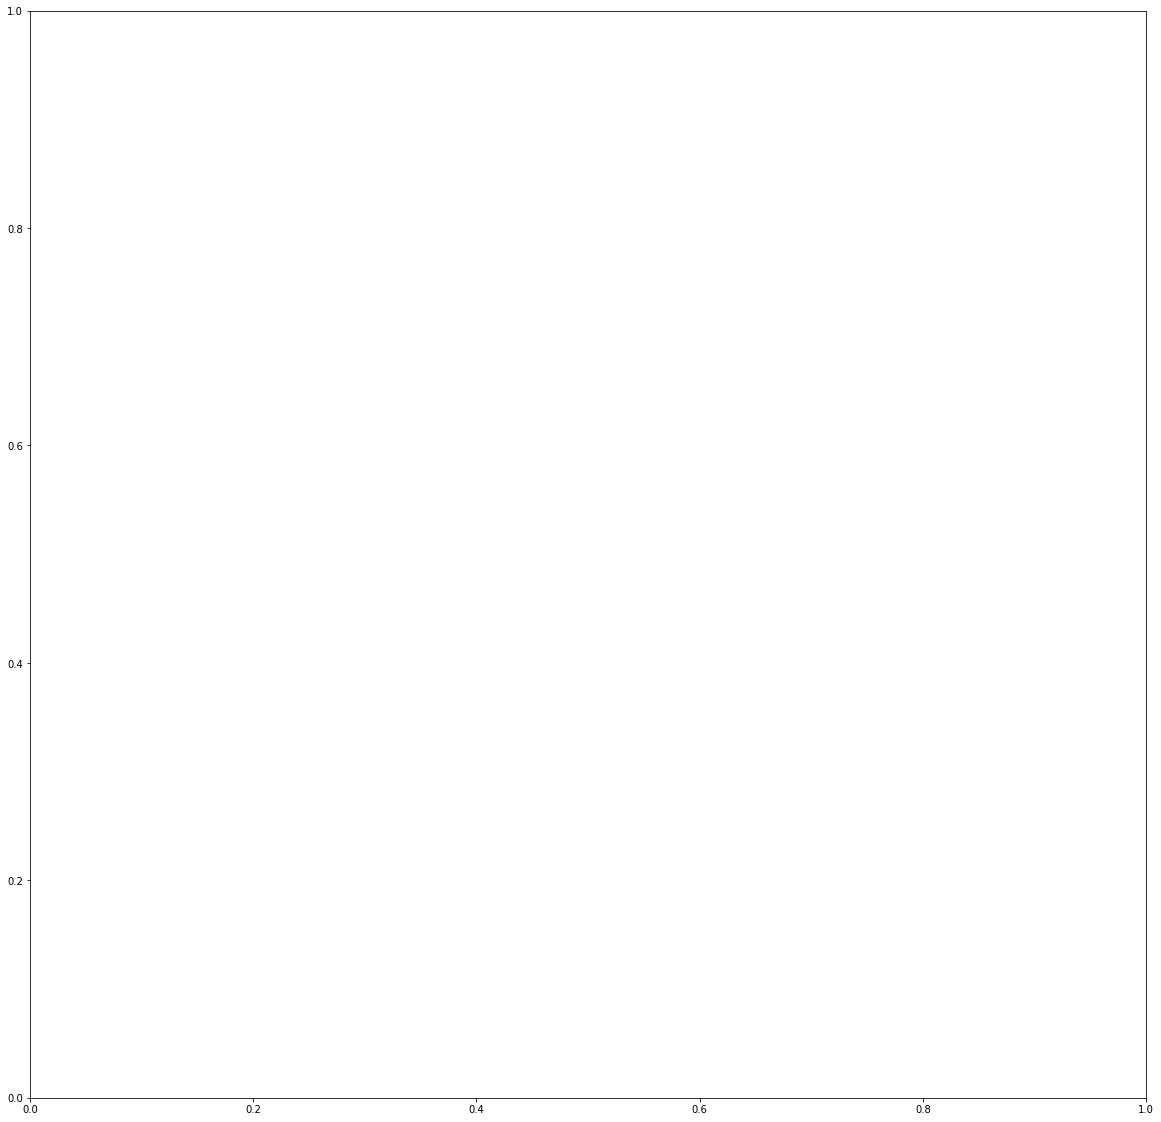

In [21]:
corrmat = data.iloc[:10].corr() 
  
f, ax = plt.subplots(figsize =(20, 20)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

quizas esto no tenga sentido. por qué? porque aunque sean variables continuas, que el vector de un usuario correlacione con otro solo significa que hablan de temas que se distribuyen linealmente de la misma manera. 

ahora, la correlacion entre vectores podria indicar algo??

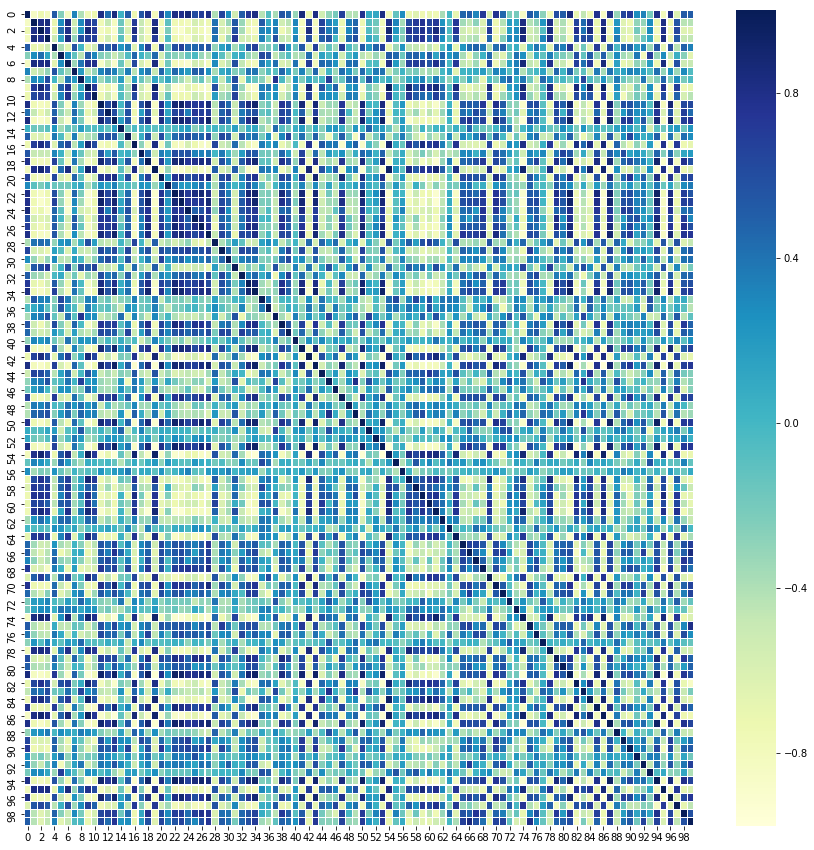

In [16]:
corrmat = data_T.corr() 
  
f, ax = plt.subplots(figsize =(15, 15)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

no


quizas podemos ver la cercania de los usuarios en base a la cercania de sus vectores.  
1) distancia euclidea entre los vectores entre pares de usuarios: siendo 0 la igualdad y 1 la diferencia extrema

In [104]:
#ojo que la ejecucion es hora y media!!
euc_corpus = pd.DataFrame(columns=v_corpus.keys(), index=v_corpus.keys(), data=0, dtype="float64")

In [105]:
for i in tqdm_notebook(v_corpus.keys()):
    for j in v_corpus.keys():
        if i != j and not np.isnan(v_corpus[i]).any() and not np.isnan(v_corpus[j]).any():
            euc_corpus.loc[i][j] = distance.euclidean(v_corpus[i], v_corpus[j])

In [106]:
euc_corpus.head()

,428308122,1669818008,2295120738,3327214991,141861159,3356423908,2458408537,2867007665,974325825825845248,1126595588,...,871715003002441728,33440371,754825293303574528,868832965492604929,1106635163130347521,15362106,1005987689945059328,1131715037285015552,229561674,60809870
428308122,0.000000,0.144627,0.030928,0.049963,0.040030,0.051310,0.023041,0.037316,0.087917,0.037739,...,0.064043,0.203335,0.090003,0.064465,0.087206,0.082352,0.074114,0.082805,0.089540,0.087833
1669818008,0.144627,0.000000,0.166964,0.104008,0.167893,0.187170,0.145494,0.123450,0.230733,0.164905,...,0.198176,0.066621,0.227588,0.193858,0.219379,0.216346,0.206333,0.219872,0.232336,0.230117
2295120738,0.030928,0.166964,0.000000,0.065877,0.027328,0.025651,0.025808,0.048558,0.069266,0.016470,...,0.041147,0.225023,0.076568,0.048675,0.065120,0.064963,0.058598,0.061161,0.071788,0.069106
3327214991,0.049963,0.104008,0.065877,0.000000,0.068423,0.085498,0.045155,0.024815,0.132476,0.062384,...,0.096968,0.161348,0.133744,0.097321,0.120544,0.119996,0.109825,0.121310,0.134718,0.131942
141861159,0.040030,0.167893,0.027328,0.068423,0.000000,0.036924,0.032693,0.051111,0.075436,0.027064,...,0.048682,0.224872,0.083566,0.044905,0.065350,0.070860,0.064398,0.070187,0.078392,0.075493


In [107]:
euc_corpus.to_csv("./data/euc_corpus.txt", sep="&")

In [111]:
euc_corpus = pd.read_csv("./data/euc_corpus.txt", sep="&").head()

In [120]:
tabla = list(euclidean.keys())[1:100]
euc_corpus_20 = pd.DataFrame(index=tabla, columns=tabla, data = euc_corpus)

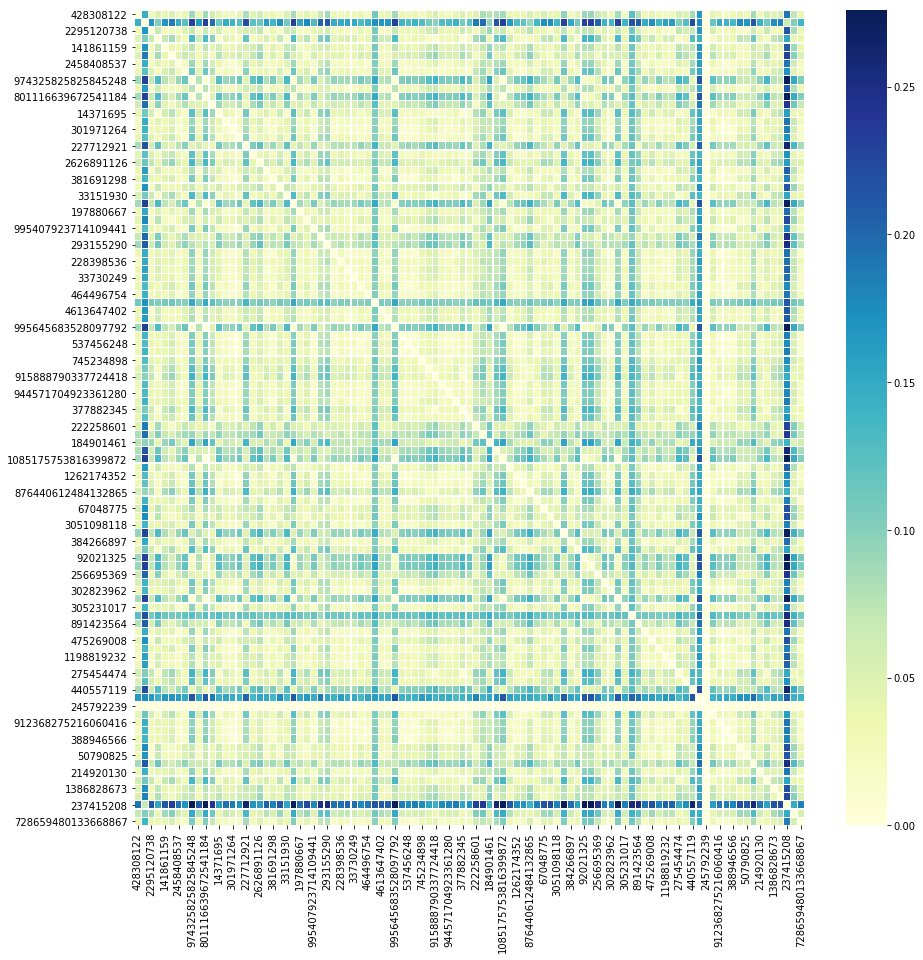

In [121]:
f, ax = plt.subplots(figsize =(15, 15)) 
sns.heatmap(euc_corpus_20, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

2) distancia de mahalanobis

In [ ]:
#ojo que la ejecucion es... tambien hora y media!!
VS_data = pd.DataFrame(columns=v_corpus.keys(), index=v_corpus.keys(), data=0)

for i in tqdm_notebook(v_corpus.keys()):
    for j in v_corpus.keys():
        if i != j and not np.isnan(v_corpus[i]).any() and not np.isnan(v_corpus[j]).any():
            VS_data.loc[i][j] = dst = distance.mahalanobis(v_corpus[i], v_corpus[j], np.linalg.inv(np.cov(pd.DataFrame(v_corpus).T)))

http://dataaspirant.com/2015/04/11/five-most-popular-similarity-measures-implementation-in-python/


https://www.machinelearningplus.com/statistics/mahalanobis-distance/




conclusion: aunque la distancia euclidea es una medida de comparacion ampliamente usada, tenemos que tener en cuenta nuestros datos para elegir la mejor. En este caso, los vectores, aunque son continuos, representan informacion categorica. Por ejemplo, en una dimension concreta de un vector, el doble de un valor no representa dos veces la unidad inicial. perro = 1, elefante =1.1


siendo así, nos decantamos por la distancia de Mahalonobis o incluso la distancia de Bhattacharyya/Cavalli-Sforza

3) Distancia Bhattacharyya / Cavalli-Sforza

In [181]:
import math


def bhattacharyya(a, b):
    """ Bhattacharyya distance between distributions (lists of floats). """
    if not len(a) == len(b):
        raise ValueError("a and b must be of the same size")
    return -math.log(sum([np.sqrt(abs(np.multiply(u,v))) for u,v in zip(list(a),list(b))]))

In [198]:
#ojo que la ejecucion es hora y media!!
bha_corpus = pd.DataFrame(columns=v_corpus.keys(), index=v_corpus.keys(), data=0, dtype="float64")

In [ ]:
for i in tqdm_notebook(v_corpus.keys()):
    for j in v_corpus.keys():
        if i != j and not np.isnan(v_corpus[i]).any() and not np.isnan(v_corpus[j]).any():
            bha_corpus.loc[i][j] = bhattacharyya(v_corpus[i], v_corpus[j])

In [ ]:
bha_corpus.to_csv("./data/bha_corpus.txt", sep="&")

In [ ]:
bha_corpus = pd.read_csv("./data/bha_corpus.txt", sep="&").head()

In [ ]:
tabla = list(bha.keys())[1:100]
bha_corpus_20 = pd.DataFrame(index=tabla, columns=tabla, data = bha_corpus)

In [ ]:
f, ax = plt.subplots(figsize =(15, 15)) 
sns.heatmap(bha_corpus_20, ax = ax, cmap ="YlGnBu", linewidths = 0.1)